## Análisis - "Las cinco grandes ligas" temporada 2015/2016 (masculina)

Tras hacer un análisis de cada una de las cinco grandes ligas durante la temporada 2015/2016, en este notebook en cuestión, vamos a analizar las cinco grandes ligas conjuntamente, es decir, suponiendo que las 5 grandes ligas son una única liga por así decirlo. Este análisis nos va a ayudar a entender que características son más importantes a la hora de tomar la decisión por parte del modelo de ML para decidir si el equipo va a ganar, perder o empatar el partido.

Cargamos los datos de los partidos para entrenar el modelo y poder hacer el estudio de explicabilidad.

In [25]:
import os
import pandas as pd

output_dir = "data/reduced/"
filename = "Top_5_leagues.csv"
output_path = os.path.join(output_dir, filename)

if os.path.exists(output_path):
    print(f"Matches from the competition loaded from {output_path}")
    matches_in_Top5Leagues = pd.read_csv(output_path)
else:
    print("You don't have data from the competition yet. Please run the notebook '0_datasets_building.ipynb' first.")

Matches from the competition loaded from data/reduced/Top_5_leagues.csv


In [26]:
matches_in_Top5Leagues.head(5)

,match_id,shots_on_target_ratio_home,shots_on_target_ratio_away,average_shots_on_target_distance_home,average_shots_on_target_distance_away,shots_inside_area_ratio_home,shots_inside_area_ratio_away,pass_success_ratio_home,pass_success_ratio_away,cross_success_ratio_home,...,percentage_shots_under_pressure_home,percentage_shots_inside_area_under_pressure_home,percentage_passes_under_pressure_home,percentage_passes_inside_area_under_pressure_home,percentage_set_piece_shots_home,percentage_set_piece_shots_inside_area_home,percentage_substitutions_home,percentage_tactical_substitutions_home,percentage_tactical_changes_home,percentage_formation_changes_home
0,3890267,0.375000,0.461538,16.622853,13.820947,0.750000,0.692308,0.832013,0.755051,0.250000,...,0.250000,0.400000,0.574713,0.50,0.266667,0.300000,0.5,0.5,0.500000,0.000000
1,3890265,0.150000,0.272727,20.255117,17.607160,0.500000,0.545455,0.772727,0.828261,0.318182,...,0.769231,0.750000,0.441718,0.75,0.680000,0.727273,0.5,0.5,0.500000,0.666667
2,3890264,0.133333,0.312500,26.271612,17.542449,0.333333,0.500000,0.767241,0.704301,0.200000,...,0.500000,0.400000,0.595376,1.00,0.476190,0.500000,0.5,0.6,0.333333,0.500000
3,3890263,0.272727,0.357143,18.619963,21.381858,0.454545,0.428571,0.688000,0.620690,0.214286,...,0.444444,0.571429,0.502924,0.50,0.458333,0.454545,0.5,0.5,1.000000,1.000000
4,3890262,0.272727,0.357143,20.860604,15.628223,0.818182,0.428571,0.490909,0.657431,0.300000,...,0.222222,0.250000,0.375000,0.60,0.400000,0.600000,0.5,0.5,0.200000,0.000000


Una vez ya tenemos los datos cargados, entrenamos el mejor modelo (seleccionado tras la experimentación) y mostramos sus resultados. El mejor modelo es un Logistic Regression que utiliza una técnica PCA para el preprocesamiento de los datos (obteniendo un 64.38% de precisión en los datos de prueba); el caso es que es complicado de hacer un estudio de explicabilidad de este tipo de modelos, por lo que vamos a utilizar uno que tiene un poco menos de precisión (63.56% en los datos de prueba) pero que el estudio de explicabilidad es más entendible y en este caso es un modelo Random Forest que utiliza una técnica de oversampling en el preprocesamiento sobre los datos de entrenamiento.

In [27]:
from src.analysis import top5Leagues_best_model

best_model_Top5Leagues, evaluation_metrics, X_train_Top5Leagues, X_test_Top5Leagues, encoder_Top5Leagues, match_ids_test = top5Leagues_best_model(matches_in_Top5Leagues)
print(f"The best model for 'The top 5 leagues' is {best_model_Top5Leagues}")
print(f"The evaluation metrics for the best model are:")
evaluation_metrics.head()

The best model for 'The top 5 leagues' is RandomForestClassifier(max_depth=6, max_features='log2', n_estimators=56,
                       random_state=42)
The evaluation metrics for the best model are:


,Train Accuracy,Test Accuracy,Precision Macro,Precision Weighted,Recall Macro,Recall Weighted,F1 Macro,F1 Weighted
Random Forest Oversampling,0.859053,0.635616,0.598653,0.626413,0.60653,0.635616,0.599698,0.628597


Una vez ya tenemos el mejor modelo entrenado comenzamos el análisis de explicabilidad.

### Estudio global

Vamos a comenzar por un estudio global. 

En este caso, al ser el mejor modelo Random Forest, nos basaremos en la importancia de las características proporcionada por el modelo a través del método `feature_importances_`.
- A diferencia de la regresión logística, que asigna coeficientes específicos a cada clase, Random Forest evalúa la relevancia de cada variable para el modelo en su conjunto, sin distinguir entre clases.
- Este modelo captura tanto relaciones lineales como no lineales, permitiendo analizar interacciones entre múltiples factores y su impacto en la predicción del resultado.
- Sin embargo, no indica la dirección del efecto de cada característica (positiva o negativa), sino únicamente su importancia relativa en el rendimiento del modelo.

El gráfico presentado a continuación muestra la importancia global de cada característica en la predicción de los resultados de los partidos en "Las cinco grandes ligas".
- Valores más altos indican que una característica tiene mayor peso en las predicciones del modelo.
- Valores cercanos a cero indican que la característica no aporta información significativa para la clasificación del resultado.

Este análisis nos permite identificar qué factores son clave en la predicción del resultado de los partidos, considerando relaciones más complejas y capturando patrones que un modelo lineal no podría detectar.

Features with zero importance across all classes:
['is_valid_last_3_matches_form_away', 'is_valid_win_last_home_match_home_team', 'is_valid_goals_scored_last_match_home', 'is_valid_goals_scored_last_match_away', 'percentage_players_off_home']


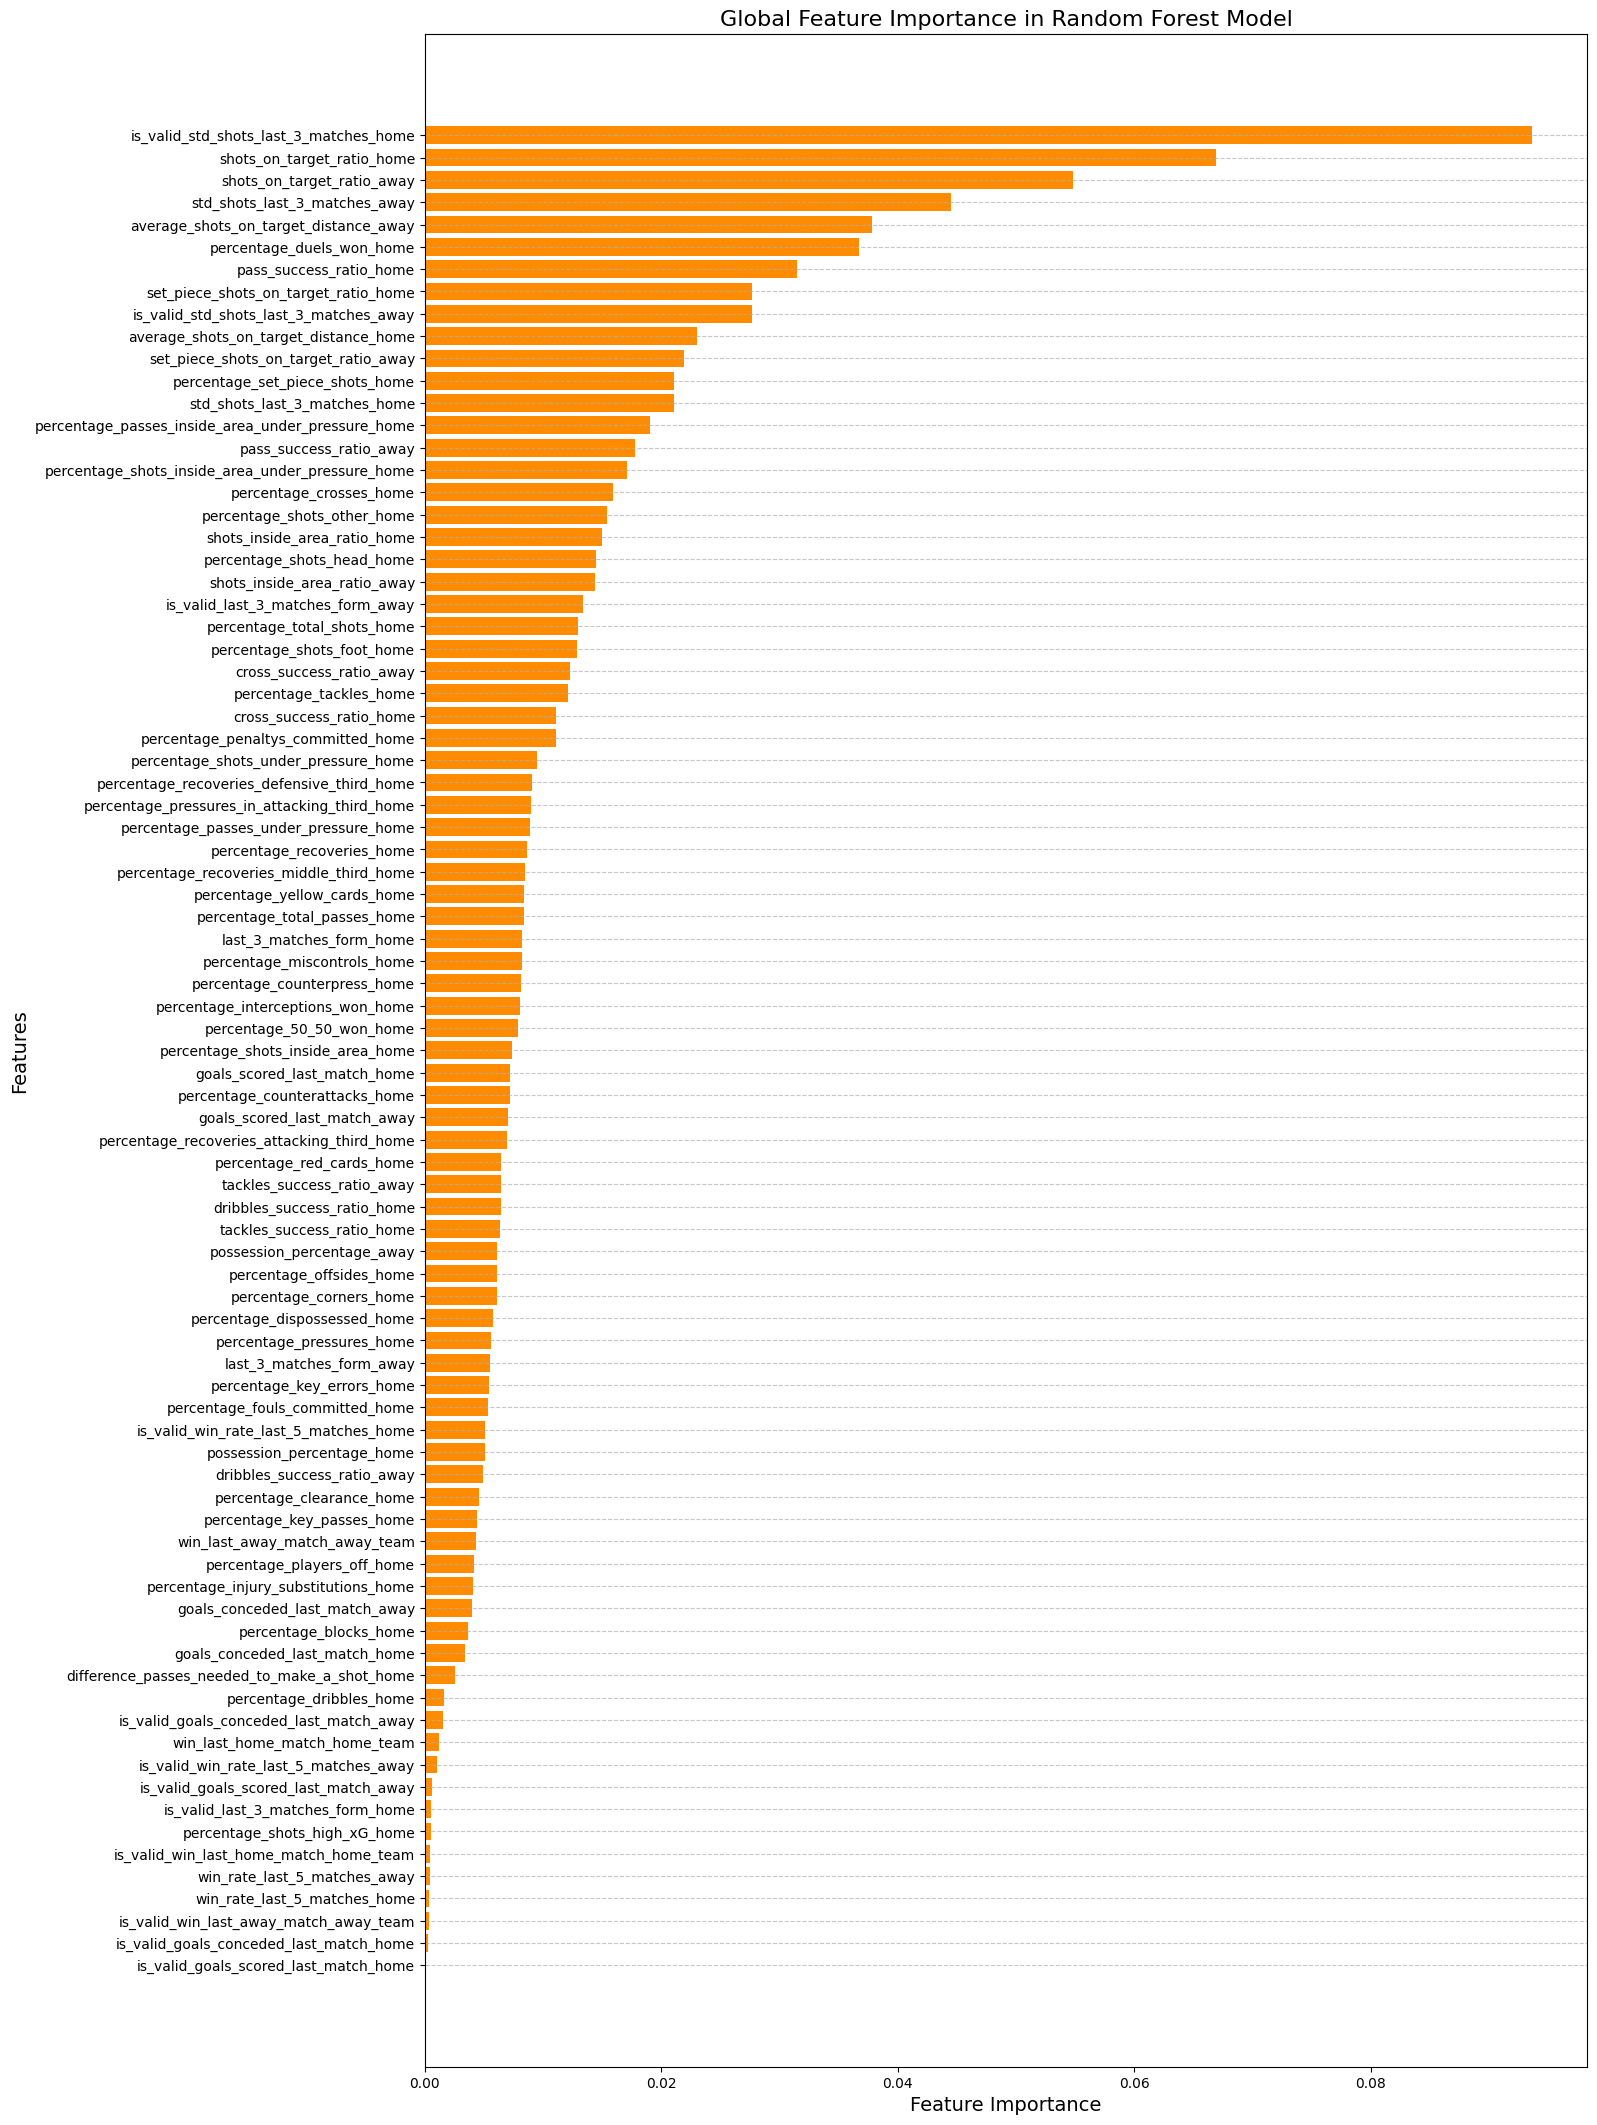

In [28]:
from src.analysis import random_forest_global_analysis

random_forest_global_analysis(best_model_Top5Leagues)

El modelo Random Forest ha determinado la relevancia de cada característica en la predicción del resultado de los partidos en "Las cinco grandes ligas". A diferencia de la Regresión Logística, aquí se mide la importancia relativa de cada variable para el modelo en su conjunto, sin distinguir entre clases específicas (victoria local, empate o victoria visitante). Vamos a analizar el gráfico:

- **Caracterísiticas más importantes en la predicción**: Las características con mayor importancia en el modelo son aquellas que han tenido un impacto significativo en la clasificación del resultado del partido. Aunque no podemos determinar si una variable favorece a un equipo u otro, sí podemos intuir que estas características han sido relevantes en la toma de decisiones del modelo.
    - `is_valid_std_shots_last_3_matches_home`: Es la característica más influyente. Esta métrica indica si es válida o no la desviación estándar de los tiros en los últimos 3 partidos del equipo local. Esto sugiere que la variabilidad en la producción ofensiva reciente del equipo local puede estar muy correlacionada con el resultado final del partido.
    - `shots_on_target_ratio_home` y `shots_on_target_ratio_away`: La precisión en los tiros a puerta, tanto del equipo local como del visitante, se sitúan como factores clave. Estos indicadores sugieren que la eficiencia ofensiva de ambos equipos es fundamental en el desenlace de los partidos.
    - `std_shots_last_3_matches_away`, `std_shots_last_3_matches_home`, `average_shots_on_target_distance_away` y `average_shots_on_target_distance_home`: La desviación estándar en el número de disparos del local y visitante y la distancia media de los tiros del equipo local y visitante aportan información adicional. Mientras que la desviación indica consistencia o irregularidad ofensiva, la distancia sugiere si los equipos buscan tiros más cercanos o arriesgan desde lejos.
    - `percentage_duels_won_home`: La cantidad de duelos ganados por el equipo local muestra que el dominio físico y competitivo en el campo puede tener un rol en los resultados. Esta métrica refleja la intensidad con la que el equipo local compite.
    - `pass_success_ratio_home` y `pass_success_ratio_away`: La calidad en la circulación del balón, medida por el porcentaje de pases acertados, es otro componente importante. Un juego fluido y preciso, por parte de ambos equipos, se asocia con mejores resultados.
    - `set_piece_shots_on_target_ratio_home`, `set_piece_shots_on_target_ratio_away` y `percentage_set_piece_shots_home`: La capacidad de transformar jugadas a balón parado en tiros peligrosos se revela como una habilidad que el modelo considera valiosa. También el porcentaje de tiros desde jugadas a balón parado de los equipo en el partido. Los equipos que aprovechan sus oportunidades desde córners o faltas tienden a ser más competitivos.
    - `percentage_shots_inside_area_under_pressure_home`, `percentage_passes_inside_area_under_pressure_home`, `percentage_shots_under_pressure_home` y `percentage_passes_under_pressure_home`: El porcentaje de tiros y pases (desde dentro del área) bajo presión de los dos equipos en el partido son una métrica importante ya que muestra como un equipo complica al otro cuando esta en su área y como es además capaz de responder el equipo ante la presión.
    - `shots_inside_area_ratio_home` y `shots_inside_area_ratio_away`: La cantidad de tiros realizados dentro del área también aparece como un buen indicador ofensivo. Estos disparos suelen tener más probabilidad de acabar en gol, lo que puede explicar su relevancia para el modelo.
    - `percentage_crosses_home`, `cross_success_ratio_home`, `cross_success_ratio_away`, `percentage_shots_other_home`, `percentage_shots_head_home` y `percentage_shots_foot_home`: Aspectos que reflejan el estilo ofensivo del equipo local, como su uso de centros o el tipo de disparos utilizados, también han sido tenidos en cuenta.
    - `percentage_total_shots_home`, `percentage_tackles_home` y `percentage_total_passes_home`: El volumen total de disparos, pases y el número de entradas defensivas refuerzan la idea de que tanto la capacidad ofensiva como la presión defensiva del equipo local son variables interpretadas como útiles por el modelo.
    - `percentage_key_errors_home` y `percentage_penaltys_committed_home`: El porcentaje de errores claves y penaltis cometidos en el partido por parte de ambos equipos también juega un papel importante.
    - `percentage_interceptions_won_home`, `percentage_pressures_in_attacking_third_home`, `percentage_recoveries_in_middle_third_home` y `percentage_recoveries_in_defensive_third_home`: También hay varias métricas defensivas que toman importancia a la hora de definir quien gana el partido.
    - `goals_scored_last_match_home` y `goals_scored_last_match_away`: El número de goles anotados en el partido justo posterior por ambos equipos cobrá importancia a la hora de decidir el ganador del partido.

- **Características sin importancia en la predicción**: El modelo ha determinado que varias características no aportan información relevante en la clasificación del resultado del partido. Esto no significa que estas variables no tengan influencia en el fútbol de "Las cinco grandes ligas", sino que, dentro de los datos analizados, el modelo no ha encontrado una relación clara con los resultados.
    - **Variable relacionadas con la validez/disponibilidad de datos recientes**: `is_valid_last_3_matches_form_away`, `is_valid_win_last_home_match_home_team`, `is_valid_goals_scored_last_match_home`, `is_valid_goals_scored_last_match_away`. Es posible que no aporten valor predictivo si ya se están utilizando otras métricas más directas.
    - **Variables que rara vez toman valores diferentes**: `percentage_players_off_home`, `percentage_injuries_substitutions`. Este tipo de métrica, más rara e infrecuente, probablemente no ha presentado patrones consistentes en los datos.
    - ****:  
    - **Métricas temporales que no toman importancia**: `goals_conceded_last_match_home`, `goals_conceded_last_match_away`, `win_last_home_match_home_team`, `win_last_away_match_away_team`, `win_rate_last_5_matches_home` y `win_rate_last_5_matches_away`. Estas métricas temporales no toman importancia.
    - **Métricas ofensivas y de juego que toman menos importancia de la esperada**: Métricas como `percentage_shots_high_xG_home` y `difference_passes_needed_to_make_a_shot` toman menos importancia de lo que podríamos esperar en un principio ya que parecía que podrían influir claramente en el juego.

**Conclusiones generales**: 

El modelo de Random Forest ha revelado que, en el conjunto de "Las cinco grandes ligas", las métricas más relevantes para predecir el resultado de los partidos están relacionadas principalmente con la eficiencia ofensiva, la consistencia en el número de tiros y la precisión en jugadas clave. Variables como la desviación estándar de los tiros en partidos recientes, la proporción de tiros a puerta, la distancia media de los disparos y el éxito en jugadas a balón parado han sido fundamentales en la clasificación del modelo.

Por el contrario, el modelo ha otorgado poca o nula importancia a factores defensivos como las recuperaciones, las presiones o los bloqueos, así como a métricas de rendimiento reciente como victorias anteriores o goles marcados en el último partido. Esto indica que, en los datos analizados, estos aspectos no han mostrado una relación consistente con el resultado final.

Es importante destacar que el modelo no ofrece información sobre la dirección del impacto de cada variable, es decir, no indica si un mayor valor en una característica favorece a un equipo u otro. Solo señala que dichas características han sido más utilizadas en las decisiones del modelo, lo que refleja su peso relativo en la predicción.

Desde un punto de vista táctico, podemos intuir que los equipos que muestran regularidad ofensiva, eficiencia en los tiros y un uso efectivo de las jugadas a balón parado tienden a estar más presentes en los patrones de éxito detectados por el modelo. Además, la atención a situaciones bajo presión sugiere que el contexto de los tiros o pases también es importante, más allá del simple volumen de acciones.

En conclusión, en el análisis conjunto de las grandes ligas europeas, el rendimiento ofensivo, la precisión y ciertos elementos del estilo de juego se perfilan como los factores más influyentes en los resultados, aportando claves útiles para la comprensión del fútbol de alto nivel en estas competiciones.

### Estudio local

Ahora comenzamos el análisis de explicabilidad utilizando SHAP. 

El análisis SHAP (SHapley Additive exPlanations) nos permite interpretar el impacto de cada característica en la predicción del modelo. A diferencia de los coeficientes lineales, SHAP captura interacciones entre variables y muestra el impacto individual de cada una en cada predicción. En este documento analizaremos los resultados obtenidos para la predicción de los partidos de "Las cinco grandes ligas".

Cada uno de los siguientes gráficos representa la importancia de las variables en la predicción de cada posible resultado:
- Victoria del equipo visitante (away_team).
- Empate (draw).
- Victoria del equipo local (home_team).

**Interpretación de los gráficos SHAP**: Cada punto en el gráfico representa un partido. Los valores en el eje X indican el impacto de una característica específica en la predicción del modelo:
- Valores positivos: Incrementan la probabilidad de que el partido termine con el resultado indicado.
- Valores negativos: Disminuyen la probabilidad del resultado.
- Color: Representa el valor de la característica. Rojo indica valores altos y azul valores bajos.

In [29]:
from src.analysis import compute_shap_values

feature_names_Top5Leagues = list(best_model_Top5Leagues.feature_names_in_)
shap_values_Top5Leagues = compute_shap_values(best_model_Top5Leagues, X_train_Top5Leagues, X_test_Top5Leagues, feature_names_Top5Leagues)

Class 0: away_team
Important features (32):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'shots_inside_area_ratio_away', 'pass_success_ratio_home', 'pass_success_ratio_away', 'cross_success_ratio_home', 'cross_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'last_3_matches_form_home', 'win_rate_last_5_matches_home', 'percentage_total_shots_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_foot_home', 'percentage_shots_head_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_crosses_home', 'percentage_corners_home', 'percentage_blocks_home', 'percentage_fouls_committed_home', 'percentage_clearance_home', 'percentage_penaltys_committed_home', 'percentage_red_cards_home', 'percentage_pressures_in_attacking_third_home', 'percentage_injury_substitution

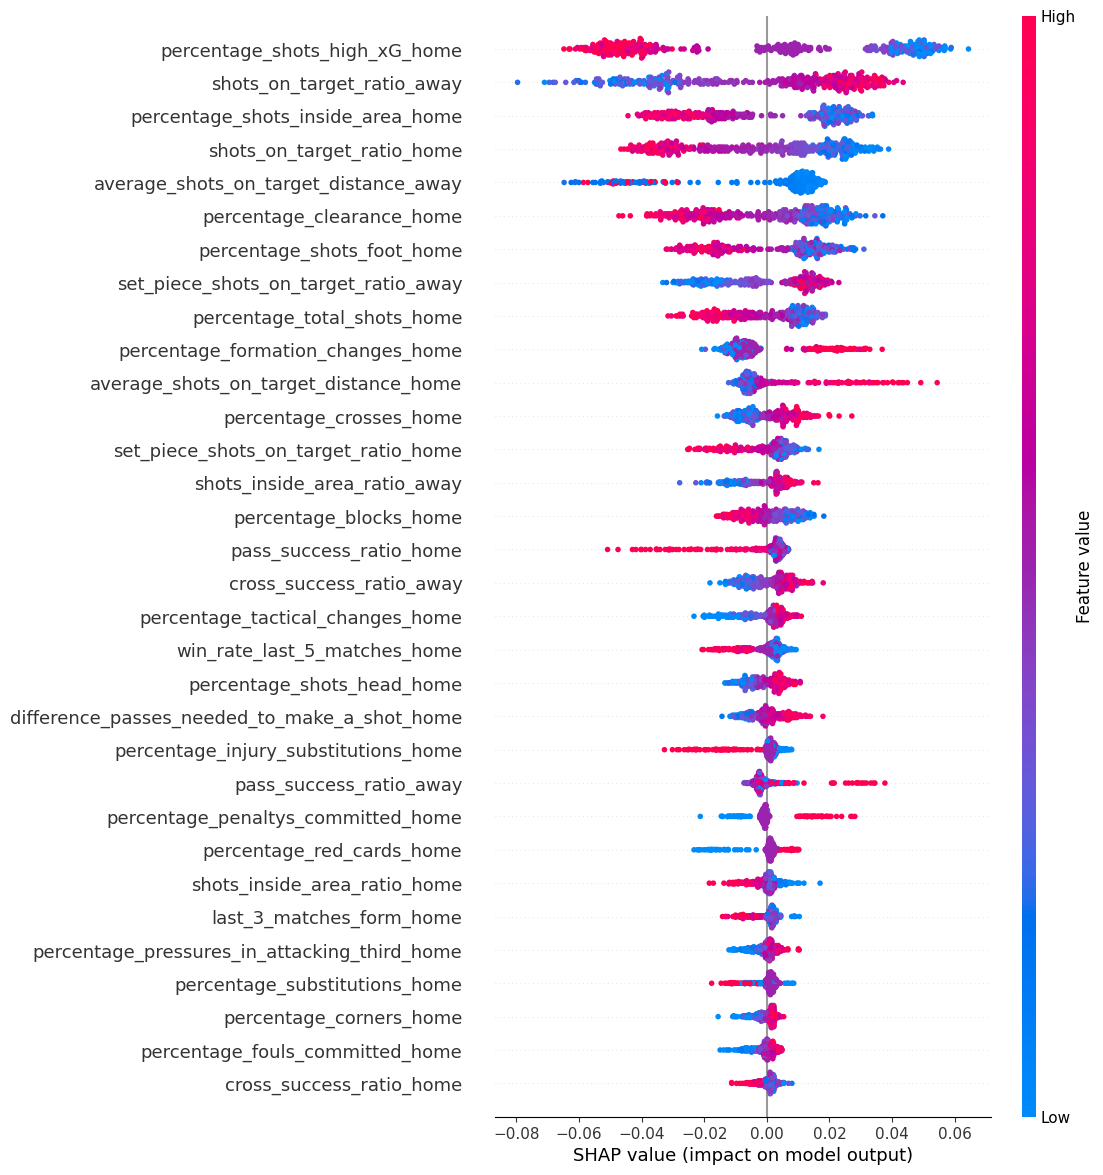

Class 1: draw
Important features (28):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'shots_inside_area_ratio_away', 'pass_success_ratio_home', 'pass_success_ratio_away', 'cross_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'win_rate_last_5_matches_home', 'percentage_total_shots_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_foot_home', 'percentage_shots_head_home', 'percentage_key_passes_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_crosses_home', 'percentage_blocks_home', 'percentage_clearance_home', 'percentage_penaltys_committed_home', 'percentage_set_piece_shots_home', 'percentage_substitutions_home', 'percentage_tactical_substitutions_home', 'percentage_tactical_changes_home', 'percentage_formation_changes_home']
Unimportant featur

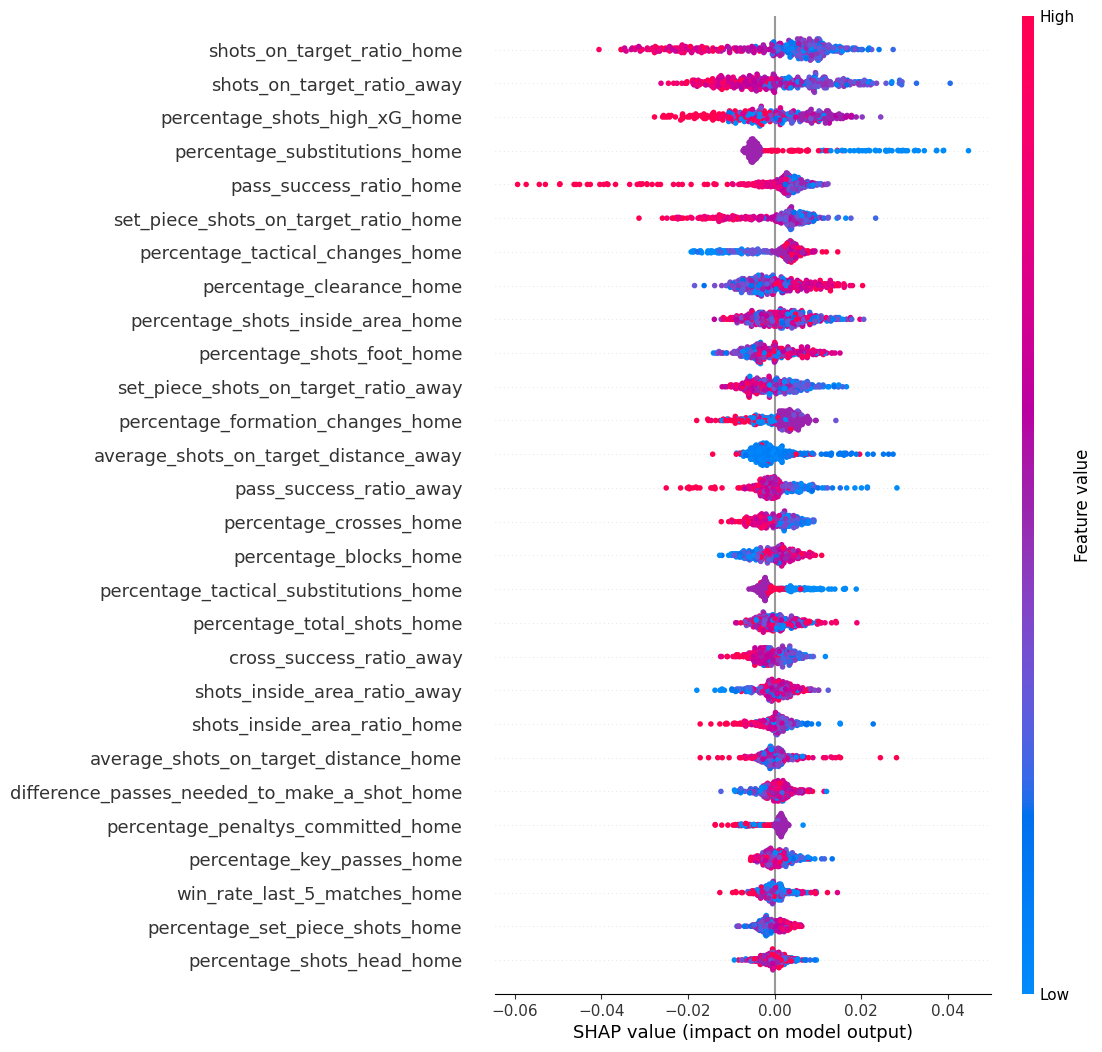

Class 2: home_team
Important features (36):
['shots_on_target_ratio_home', 'shots_on_target_ratio_away', 'average_shots_on_target_distance_home', 'average_shots_on_target_distance_away', 'shots_inside_area_ratio_home', 'shots_inside_area_ratio_away', 'pass_success_ratio_home', 'pass_success_ratio_away', 'cross_success_ratio_home', 'cross_success_ratio_away', 'set_piece_shots_on_target_ratio_home', 'set_piece_shots_on_target_ratio_away', 'last_3_matches_form_home', 'win_rate_last_5_matches_home', 'percentage_total_shots_home', 'percentage_shots_high_xG_home', 'percentage_shots_inside_area_home', 'percentage_shots_foot_home', 'percentage_shots_head_home', 'percentage_key_passes_home', 'difference_passes_needed_to_make_a_shot_home', 'percentage_crosses_home', 'percentage_corners_home', 'percentage_blocks_home', 'percentage_duels_won_home', 'percentage_fouls_committed_home', 'percentage_clearance_home', 'percentage_penaltys_committed_home', 'percentage_red_cards_home', 'percentage_pressure

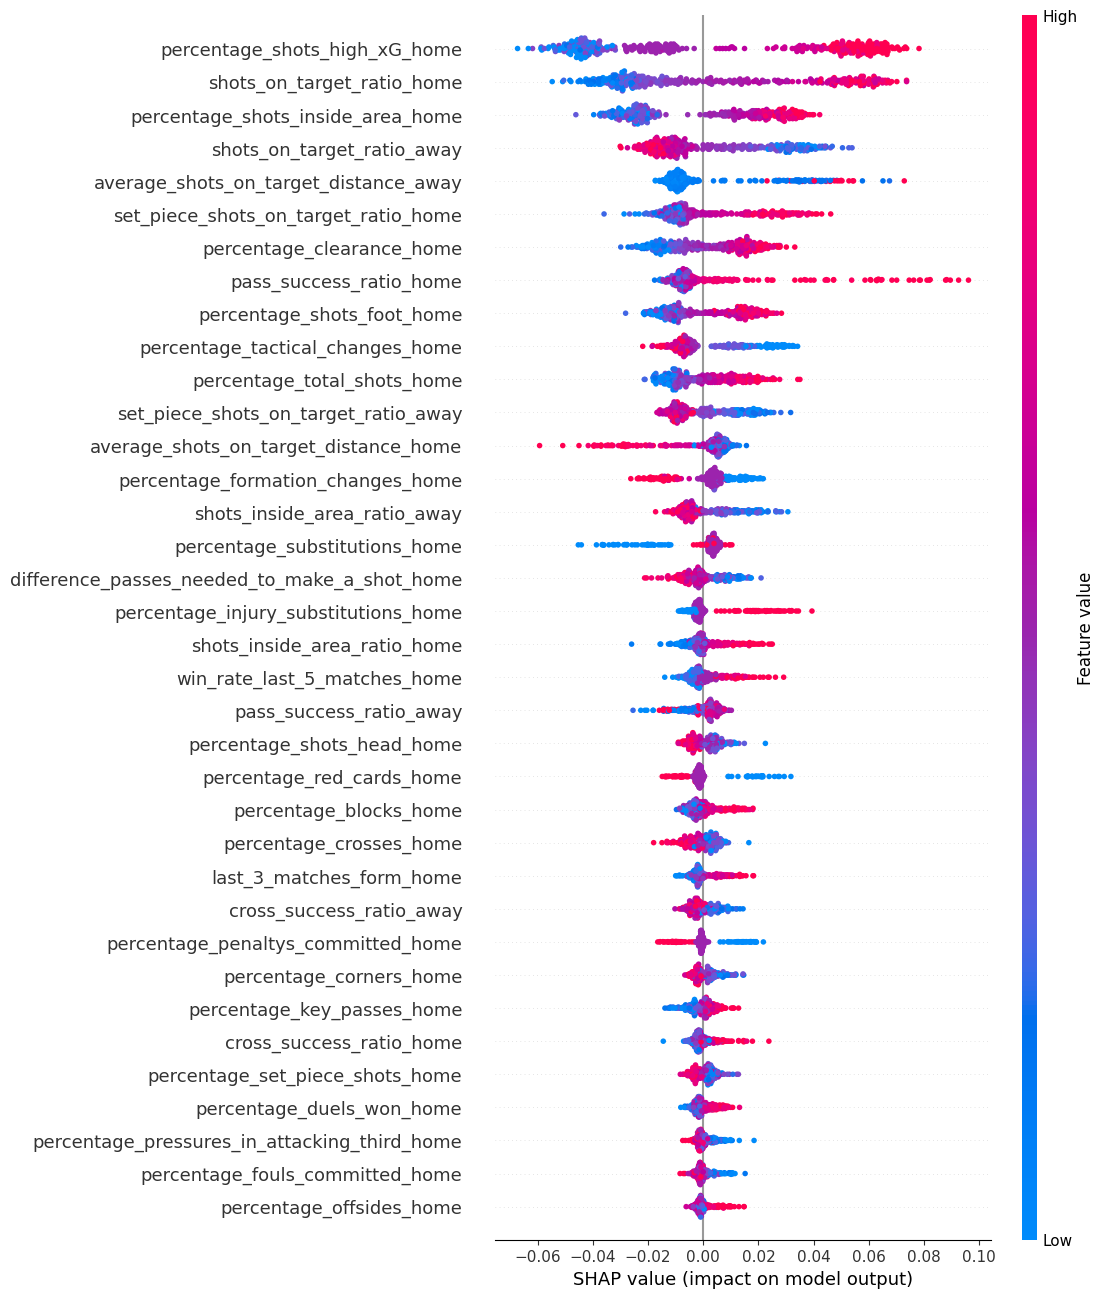

In [30]:
from src.analysis import plot_shap_summary

plot_shap_summary(shap_values_Top5Leagues, feature_names_Top5Leagues, encoder_Top5Leagues, threshold=0.002)

Vamos a analizar cada uno de los gráficos:

- **Victoria del equipo visitante**: Este gráfico muestra las características que favorecen o disminuyen la probabilidad de victoria del equipo visitante en "Las cinco grandes ligas".
    - **Características que favorecen la victoria del equipo visitante**: 📈
        - `shots_on_target_ratio_away`: Un alto porcentaje de tiros a puerta del equipo visitante indica un ataque efectivo, lo que eleva sus probabilidades de marcar y ganar.
        - `set_piece_shots_on_target_ratio_away`: La precisión en tiros a puerta desde jugadas a balón parado es una ventaja clave para que el visitante aproveche oportunidades claras.
        - `percentage_formation_changes_home` y `percentage_tactical_changes_home`: Muchos cambios tácticos o de formación por parte del equipo local pueden reflejar inestabilidad o que está siendo superado, beneficiando al visitante.
        - `average_shots_on_target_distance_home`: Si el equipo local realiza sus disparos desde distancias lejanas, sus oportunidades de gol suelen ser de menor calidad, lo que favorece al visitante.
        - `shots_inside_area_ratio_away`: Si el equipo visitante tiene un buen ratio de tiros desde dentro del área aumentan sus opciones de ganar el partido ya que son tiros más peligrosos.
        - `percentage_crosses_home`: Si el equipo local realiza más centros en el partido que el visitante en el partido puede significar que centra su juego en centros debido a que no encuentra claridad de ocasiones de otra forma lo que hace que dependa mucho de este tipo de jugadas y aumenten las opciones de que el equipo visitante gane el partido.
        - `cross_success_ratio_away`: Si el visitante tiene una alta precisión en centros, puede generar más ocasiones claras de gol.
        - `percentage_shots_head_home`: Un equipo local que realiza muchos tiros de cabeza puede depender mucho de este tipo de tiros que suelen ser menos peligrosos que los tiros con el pie, disminuyendo así sus opciones de ganar el partido.
        - `difference_passes_needed_to_make_a_shot`: Si el equipo local necesita más pases para hacer un disparo que el equipo visitante puede reflejar que su juego es predecible y poco directo, aumentando así las opciones de ganar el partido el equipo visitante.
        - `percentage_penaltys_committed_home` y `percentage_red_cards_home`: El equipo local que comete penaltis o sufre expulsiones queda en desventaja numérica o concede oportunidades claras, aumentando las chances del visitante.
        - `percentage_fouls_committed_home`: Un equipo local que comete muchas faltas puede provocar ocasiones claras a favor del rival, además que también puede simbolizar la desesperación del equipo local; aumentando así las opciones de ganar del equipo visitante.
    - **Características que no favorecen la victoria del equipo visitante**: 📉
        - `percentage_shots_high_xG_home`: Un equipo local que genera más ocasiones de gol con alto xG que el rival, está creando peligro real, lo que dificulta la victoria del visitante.
        - `shots_on_target_ratio_home`: Si el local tiene alta precisión, representa una amenaza constante que pone en jaque al equipo visitante.
        - `percentage_shots_inside_area_home` y `shots_inside_area_ratio_home`: Un equipo local que dispara con frecuencia desde dentro del área suele tener más chances de marcar, lo que reduce las opciones visitantes.
        - `percentage_clearance_home` y `percentage_blocks_home`: Una defensa local sólida que despeja y bloquea tiros reduce las opciones del visitante de crear ocasiones.
        - `percentage_shots_foot_home` y `percentage_total_shots_home`: Un equipo local que realiza más tiros que el equipo visitante con los pies (tiros más peligrosos) y más tiros en general en el partido, reduce las opciones de que gane el equipo visitante.
        - `set_piece_shots_on_target_ratio_home`: Si el equipo local también es efectivo en jugadas a balón parado, iguala o supera la amenaza del visitante.
        - `pass_success_ratio_home`: Un equipo local con buena circulación de balón puede tener mayor control del partido, lo que limita las oportunidades del rival.
        - `win_rate_last_5_matches_home` y `last_3_matches_form_home`: Un buen rendimiento reciente del equipo local puede traducirse en un estado de forma que complica la victoria visitante.
        - `percentage_injuries_substitutions_home` y `percentage_substitutions_home`: Si el equipo local realiza más substituciones que el equipo rival puede deberse a que quiere mantener el ritmo en el partido y no decaer en sus ocasiones, disminuyendo así las opciones del equipo visitante.
        - `cross_success_ratio_home`: Si el local tiene una alta precisión en centros, puede generar más ocasiones claras de gol.
    - **Conclusión**: La victoria del equipo visitante en los partidos de las cinco grandes ligas europeas se ve influenciada principalmente por su efectividad ofensiva y la incapacidad del equipo local para dominar el juego. Factores como un alto porcentaje de tiros a puerta y precisión en jugadas a balón parado indican un visitante que sabe aprovechar sus oportunidades. Además, si el equipo local realiza muchos cambios tácticos o de formación, puede reflejar desorganización o debilidad en su planteamiento, lo que favorece al rival. También juegan a favor del visitante aspectos como una mayor eficiencia en centros, disparos desde zonas peligrosas o que el equipo local tenga comportamientos defensivos o disciplinarios perjudiciales, como cometer penaltis o recibir tarjetas rojas. En cambio, las probabilidades de que el equipo visitante gane disminuyen cuando el equipo local muestra solidez tanto en ataque como en defensa. Un alto porcentaje de tiros con alta expectativa de gol, precisión en los disparos y dominio del área rival con tiros frecuentes desde zonas peligrosas indican que el equipo local está generando peligro constante. Asimismo, una buena circulación del balón y una defensa que bloquea o despeja bien hacen más difícil que el equipo visitante se imponga. Si además el equipo local llega en buena forma reciente y realiza sustituciones estratégicas para mantener la intensidad, el visitante tendrá más dificultades para conseguir la victoria.

- **Empate**: Este gráfico muestra las características que favorecen o disminuyen la probabilidad de empate en un partido en "Las cinco grandes ligas". El empate en un partido se ve influenciado por el equilibrio entre ambos equipos en aspectos ofensivos, defensivos y de control del juego.
    - **Características que favorecen el empate**: 📈
        - `percentage_shots_high_xG_home`: Si el ambos equipos generar un número parecido de tiros con alto xG, aumentan las opciones de empate ya que ambos están creando un peligro similar en esta faceta.
        - `percentage_substitutions_home`: Si el equipo local o el visitante realizan muchas substituciones, es decir, un equipo muchas comparadas con el otro, aumentan las opciones de empate ya que esto puede interpretarse como que el equipo que ha realizado muchos cambios se esta viendo por detrás en el juego y ha introducido cambios efectivos para equilibrar el juego.
        - `percentage_tactical_changes_home`: Si el equipo local realiza un cambio táctico para mejorar su influencia en el partido porque se está viendo superado, aumentan las opciones de empate.
        - `percentage_clearance_home` y `percentage_blocks_home`: Un equipo local que realiza muchos despejes hace aumentar las opciones de ganar el partido debido a que tiene una defensa férrea y tiene complicado que le anoten un gol.
        - `percentage_formation_changes_home`: Si ambos equipos realizan aproximadamente el mismo número de cambios en la formación aumentan las opciones de que se de un empate.
        - `average_shots_on_target_distance_away`: Disparos desde distancias lejanas por parte del equipo visitante refleja su falta de efectividad ofensiva lo que hace que aumenten las opciones de que se de un empate por las dificultades del equipo visitante de marcar.
        - `percentage_set_piece_shots_home`: Si el equipo local realiza más tiros desde jugadas a balón parado en el partido, aumentan las opciones de empate si no es capaz de convertirlas.
    - **Características que no favorecen el empate**: 📉
        - `shots_on_target_ratio_home` y `shots_on_target_ratio_away`: Un alto porcentaje de tiros a puerta del equipo local y/o visitante indica un ataque efectivo, lo que eleva sus probabilidades de marcar y ganar.
        - `pass_success_ratio_home` y `pass_success_ratio_away`: Un equipo local/visitante con buena circulación de balón puede tener mayor control del partido, lo que limita las oportunidades del rival.
        - `set_piece_shots_on_target_ratio_home` y `set_piece_shots_on_target_ratio_away`: Si el equipo local/visitante tiene un alto ratio de tiros a puerta en tiros a jugadas a balón parado aumentan sus opciones de ganar el partido.
        - `cross_success_ratio_away`: Si el equipo visitante tiene un alto porcentaje de centros acertados aumentan sus opciones de ganar el partido ya que están creando peligro.
        - `shots_inside_area_ratio_home`: Si aumenta el ratio de tiros desde dentro del área del equipo local, disminuyen las opciones de empate ya que se crea más peligro.
    - **Conclusión**: El empate se ve favorecido cuando el partido transcurre de forma equilibrada, sin una clara superioridad de un equipo sobre el otro. Factores como un número similar de tiros con alto xG, cambios tácticos o de formación para adaptarse al rival, o una falta de efectividad ofensiva del equipo visitante (por ejemplo, al realizar tiros desde lejos) ayudan a mantener el partido igualado. Además, defensas sólidas del equipo local que despejan y bloquean con frecuencia también contribuyen a sostener el marcador sin goles o con igualdad. Por el contrario, las probabilidades de empate se reducen cuando alguno de los equipos muestra un rendimiento ofensivo claramente superior. Altos valores en precisión en tiros a puerta, efectividad en jugadas a balón parado o centros precisos sugieren que uno de los equipos está generando más peligro y puede romper la igualdad. Asimismo, una alta precisión en los pases suele ir ligada a un mayor control del juego, lo que también puede inclinar la balanza hacia una victoria para uno de los lados.

- **Victoria del equipo local**: Este gráfico muestra las características que favorecen o disminuyen la probabilidad de victoria del equipo local en "Las cinco grandes ligas".
    - **Características que favorecen la victoria del equipo local**: 📈
        - `percentage_shots_high_xG_home`: Cuando el equipo local realiza tiros con alto valor de xG (expected goals), indica que está generando ocasiones de alta calidad, lo que incrementa considerablemente sus probabilidades de marcar.
        - `shots_on_target_ratio_home`: Una alta precisión en los disparos del equipo local sugiere un ataque efectivo y constante.
        - `percentage_shots_inside_area_home` y `shots_inside_area_ratio_home`: Cuantos más tiros desde dentro del área realice el equipo local, más aumentan sus opciones de gol, ya que suelen ser más peligrosos.
        - `set_piece_shots_on_target_ratio_home`: La precisión en jugadas a balón parado también es clave para abrir el marcador o ampliarlo.
        - `percentage_clearance_home`, `percentage_blocks_home`: Aunque son defensivas, estas acciones protegen el resultado cuando el equipo ya va por delante. Una buena defensa es fundamental para no encajar goles y ganar partidos.
        - `pass_success_ratio_home`: Una buena circulación de balón permite mantener el control del juego y generar más ocasiones.
        - `percentage_shots_foot_home`: Un mayor porcentaje de tiros con el pie, generalmente más certeros que los de cabeza, mejora las posibilidades de marcar.
        - `percentage_total_shots_home`: Más volumen de disparos implica más presión ofensiva, lo que inclina el partido a favor del local.
        - `percentage_substitutions_home` y `percentage_injury_substitutions_home`: El uso efectivo de sustituciones (por estrategia o por lesión) puede revitalizar el equipo y mejorar el rendimiento.
        - `win_rate_last_5_matches_home` y `last_3_matches_form_home`: Un equipo local en buena forma suele llegar con más confianza y solidez.
        - `percentage_key_passes_home`: La creación de oportunidades claras mediante pases clave está estrechamente ligada al peligro generado.
        - `percentage_duels_won_home`: Dominar en los duelos individuales permite imponer un ritmo favorable y recuperar más balones.
        - `cross_success_ratio_home`: Si el equipo local tiene un alto porcentaje de centros acertados aumentan sus opciones de ganar el partido ya que están creando peligro.
    - **Características que no favorecen la victoria del equipo local**: 📉
        - `shots_on_target_ratio_away`: Si el visitante tiene una buena precisión en los tiros, podría ser una amenaza constante.
        - `percentage_tactical_changes_home` y `percentage_formation_changes_home`: Cambios constantes en la estrategia o formación por parte del equipo local podrían reflejar inseguridad o falta de control, lo que perjudica sus posibilidades de victoria.
        - `set_piece_shots_on_target_ratio_away`: La efectividad del rival en jugadas a balón parado puede generar oportunidades de empatar o dar vuelta el partido.
        - `average_shots_on_target_distance_home`: Disparos lejanos del equipo local representan falta de peligro lo que hace que disminuyan sus opciones de ganar el partido.
        - `shots_inside_area_ratio_away`: Si el visitante también tiene un buen ratio de tiros desde dentro del área, la defensa local puede verse comprometida.
        - `difference_passes_needed_to_make_a_shot`: Si el equipo local necesita más pases para hacer un disparo que el equipo visitante puede reflejar que su juego es predecible y poco directo, disminuyendo así sus opciones de ganar el partido.
        - `percentage_shots_head_home`: Un equipo local que realiza muchos tiros de cabeza puede depender mucho de este tipo de tiros que suelen ser menos peligrosos que los tiros con el pie, disminuyendo así sus opciones de ganar el partido.
        - `percentage_red_cards_home`, `percentage_penaltys_committed_home`: Acciones negativas del equipo local como tarjetas rojas y penalis afectan directamente su rendimiento y aumentan el riesgo de perder la ventaja.
        - `cross_success_ratio_away`: Centros precisos del equipo visitante también generan peligro y reducen las opciones de victoria del equipo local.
    - **Conclusión**: La victoria del equipo local está fuertemente condicionada por su efectividad ofensiva, solidez defensiva y consistencia táctica. Variables como un alto porcentaje de tiros a puerta, disparos con alto xG y tiros desde dentro del área aumentan significativamente las probabilidades de victoria, ya que reflejan un equipo que genera peligro constante y de calidad. Además, el dominio en aspectos como los pases clave, los centros precisos, los duelos ganados y una defensa eficiente (despejes y bloqueos) refuerzan esta ventaja. Por otra parte, ciertos factores reducen las probabilidades de éxito. Entre ellos destacan la efectividad ofensiva del equipo visitante (shots_on_target_ratio_away), así como la inestabilidad táctica del local (muchos cambios de formación o estrategia). Asimismo, un equipo local que necesita muchos pases para generar un disparo, dispara desde lejos o depende de tiros de cabeza tiende a tener un ataque menos peligroso. También, las acciones negativas como cometer penaltis o sufrir expulsiones impactan directamente en sus opciones de victoria. En resumen, el triunfo local está estrechamente ligado a un juego ofensivo directo y preciso, combinado con una defensa que sabe aguantar el resultado y minimizar errores.

- **Conclusiones generales**:
    - *Victoria del equipo visitante*: La victoria del equipo visitante se explica principalmente por su capacidad de generar peligro con eficacia y aprovechar los errores o debilidades del equipo local. Un alto porcentaje de tiros a puerta, precisión en jugadas a balón parado y disparos desde zonas favorables como dentro del área son claves. Además, si el equipo local presenta inestabilidad táctica (muchos cambios de formación o estrategia), dispara desde lejos, o comete errores disciplinarios como penaltis o tarjetas rojas, el visitante se ve beneficiado. El visitante también saca ventaja cuando el local depende de tiros menos efectivos (como los de cabeza) o muestra un juego predecible con ataques poco directos. En contraste, si el equipo local es sólido en ataque, domina en tiros con alto xG, maneja bien la posesión y se defiende eficazmente con despejes y bloqueos, se reducen significativamente las probabilidades de victoria visitante.
    - *Empate*: Los empates suelen surgir cuando no hay una clara superioridad de un equipo sobre el otro, y el partido se mantiene en equilibrio tanto en ataque como en defensa. Factores como una cantidad similar de tiros con alto xG, disparos del visitante desde distancias lejanas, o cambios tácticos para igualar el juego favorecen el empate. También ayudan las defensas sólidas, con bloqueos y despejes frecuentes, y un bajo acierto ofensivo. Por el contrario, el empate se ve amenazado cuando alguno de los equipos destaca claramente en tiros a puerta, jugadas a balón parado o precisión en los pases, ya que estas acciones pueden romper la igualdad del marcador y decantar el resultado a favor de uno de los dos lados.
    - *Victoria del equipo local*: El triunfo del equipo local está fuertemente asociado a su eficacia ofensiva y al control general del juego. Disparos de alta calidad (xG alto), frecuencia de tiros desde dentro del área, precisión en centros y pases clave, y un elevado número de duelos ganados son indicadores claros de superioridad. Además, una defensa que bloquea, despeja y comete pocos errores disciplinares contribuye a proteger la ventaja una vez obtenida. El estado de forma reciente y una buena gestión de los cambios también fortalecen sus opciones. Sin embargo, las probabilidades de victoria disminuyen cuando el equipo local muestra inestabilidad táctica, dependencia de jugadas menos efectivas (como tiros de cabeza o desde lejos), o si el rival tiene una alta efectividad en ataque y a balón parado.
    - *Factores no determinantes*: En este análisis, ciertos factores como la posesión del balón, el número de pases totales o algunas estadísticas físicas (como los 50/50 ganados, recuperaciones o presiones en ciertas zonas del campo) han resultado tener un impacto marginal en la predicción del resultado. Aunque estas variables pueden influir indirectamente en el desarrollo del partido, por sí solas no han mostrado un peso significativo a la hora de determinar si un equipo gana, empata o pierde. Esto sugiere que los aspectos más directamente relacionados con la efectividad en las áreas (ataque y defensa) y el contexto táctico son los verdaderos determinantes en el desenlace del partido.